# ABOUT THIS NOTEBOOK
## Purpose
This notebook attempts to fit various machine learning models on the data set.    
Results of the model fitting are analyzed.
## Input
'data_set.pickle' generated by 'data_processing.ipynb'.
## Output
Results of model fitting: plots, parameters and scores.
## Tasks Performed
* Load library packages
* Load pickle file
* Split data into train & test sets
    * Train: weeks 1 & 2, Test: week 3
    * Perform feature scaling
* Implement functions for common tasks
    * Scoring
    * Learning curves
    * Validation curves
    * Hyperparameter selection
* Run the following algorithms:
    * Random Forest Regressor
    * K Nearest Neighbors
    * Gradient Boosting Regressor
* For each of the algorithms perform the following:
    * Validation curve plots
    * Hyperparameter selection

# LOAD LIBRARY PACKAGES

In [1]:
# Import the required library packages
import os
import re
import timeit

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

from six.moves import cPickle as pickle

# Settings for matplotlib, Seaborn
%matplotlib inline
sns.set_style('whitegrid')

# Set font sizes for matplots
plt.rcParams.update({'font.size': 15, 
                     'legend.fontsize': 'medium', 
                     'axes.titlesize': 'medium', 
                     'axes.labelsize': 'medium'})

print 'Read in packages from os, numpy, pandas, matplotlib, seaborn, sklearn & six'

Read in packages from os, numpy, pandas, matplotlib, seaborn, sklearn & six


# LOAD PICKLE FILE

In [2]:
pickle_file = 'data_set.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    pdata_set = save['data_set']
    del save
    print 'Loaded ptrain_set', pdata_set.shape
    
f.close()

Loaded ptrain_set (199584, 55)


In [3]:
pdata_set.columns.values

array(['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
       'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
       'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature',
       'pollution', 'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4',
       'poi_cluster', 'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4', 'dist_0',
       'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
       'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 'ts_0',
       'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7', 'weekday_0',
       'weekday_1', 'weekday_2', 'poi_0', 'poi_1', 'poi_2', 'wthr_0',
       'wthr_1', 'wthr_2', 'wthr_3'], dtype=object)

# ADD GAP FOR PREVIOUS TIME SLOTS

In [4]:
# Create new gap features for previous 3 time slots
pdata_set['gap_t-1'] = (pdata_set['demand_t-1'] - pdata_set['supply_t-1'])
pdata_set['gap_t-2'] = (pdata_set['demand_t-2'] - pdata_set['supply_t-2'])
pdata_set['gap_t-3'] = (pdata_set['demand_t-3'] - pdata_set['supply_t-3'])

# SPLIT DATA INTO TRAIN & TEST SETS

## Use weeks 1 & 2 for training, week 3 for test

In [5]:
train_days     = range(1,15)
test_days      = range(15, 22)

X_train     = pdata_set[(pdata_set['num_day'].isin(train_days))]
X_test      = pdata_set[(pdata_set['num_day'].isin(test_days))]

print "Shape of X_train, X_test:", X_train.shape, X_test.shape, "\n\n"

Shape of X_train, X_test: (133056, 58) (66528, 58) 




## Generate scaled features for train & test sets

In [6]:
import warnings
warnings.filterwarnings('ignore')

gap_predictors = ['demand_t-1', 'demand_t-2', 'demand_t-3',
                  'supply_t-1', 'supply_t-2', 'supply_t-3',
                  'poi_pc1', 'poi_pc2',
                  'tj_lvl1', 'tj_lvl2', 'tj_lvl3',
                  'ts_0', 'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7',
                  'pollution', 'temperature',
                  'wthr_0', 'wthr_1', 'wthr_2', 'wthr_3',
                  'gap_t-1', 'gap_t-2', 'gap_t-3',
                  'time_slot', 'week_day'
                 ]   

gX_train = []
gy_train = []
gX_test  = []
gy_test  = []

# Use StandardScaler to achieve zero mean and unit variance
# Generate two scalers: input and target
input_scaler = StandardScaler().fit(pdata_set[gap_predictors])
target_scaler = StandardScaler().fit(pdata_set['gap'])

# Scale both training & test data
gX_train  = input_scaler.transform(X_train[gap_predictors])
gy_train  = target_scaler.transform(X_train['gap'])

gX_test = input_scaler.transform(X_test[gap_predictors])
gy_test = target_scaler.transform(X_test['gap'])

# IMPLEMENT FUNCTIONS FOR COMMON TASKS

## Scoring

In [7]:
# Generate Demand Supply Gap Metrics based on provided fit functions
# Assumes expected values for gap is in namesake column
def gap_estimate(**kwargs):
    """
    Generate scores for gap.
    
    Parameters
    ----------
    gX_train  : array containing train features
    gX_test   : array containing test features
    g_fitfunc : function to use for predicting
    """
    
    gX_train     = kwargs["gX_train"]
    gX_test      = kwargs["gX_test"]
    g_fitfunc    = kwargs["g_fitfunc"]
    
    print "\n\nGAP FORECASTING"
    print     "==============="

    # Generate predictions for train & test sets
    gy_pred_train    = target_scaler.inverse_transform(g_fitfunc.predict(gX_train))
    gy_pred_test     = target_scaler.inverse_transform(g_fitfunc.predict(gX_test))

    # Extract expected train & test values
    gy_train    = X_train['gap']
    gy_test     = X_test['gap']

    # Evaluate scores and print results
    print_score(gy_train, gy_pred_train, gy_test, gy_pred_test) 
    return

def print_score(y_train, y_pred_train, y_test, y_pred_test):
    
    """
    Present the MSE, R^2 and MAPE scores for train & test sets as a table.

    Parameters
    ----------
    y_train      : Array containing expected values for train set
    y_pred_train : Array containing predicted values for train set
    y_test       : Array containing expected values for test set
    y_pred_test  : Array containing predicted values for test set
    """
    
    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    # Assumes data is for 144 time slots, 14 days (train), 7 days (test)
    mpscore_train    = mape_score(y_train,    y_pred_train, ((144*14)-1))
    mpscore_test     = mape_score(y_test,     y_pred_test, ((144*7)-1))


    sets_list = ["TRAIN", "TEST"]

    m2_scores = [m2score_train, m2score_test]
    r2_scores = [r2score_train, r2score_test]
    mp_scores = [mpscore_train, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'

    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.3f}\t\t{2:.3f}\t\t{3:.3f}' .format(s, m, r, mp)


def mape_score(exp, pred, q):
    
    """
    Generate the MAPE score value.

    Parameters
    ----------
    exp  : Array containing expected values
    pred : Array containing predicted values
    q    : Constant representing (number of days * number of time slots) - 1
    """
    
    mape = 0.0
    n = 66.0
    
    for gap, gapX in zip(exp, pred):
        if gap > 0:
            mape += 1.0 * abs((gap-gapX)/gap)
    return (mape/(n*q))

In [8]:
# Create a scorer function using the MAPE metric
# Use the training data size (144 time slots * 14 days) for q value

mape_scorer = make_scorer(mape_score, greater_is_better=False, q=((144*14)-1))

## Generate Learning & Validation Curves

In [9]:
def generate_learningcurves(sparse=False,**kwargs):
    ''' Generate learning curves by varying training sizes.
    Use Training vs Cross-validation curves.
    
    Arguments:
    gX_train -- Input features for training
    gy_train -- Target values for training
    alg -- Algorithm used for estimation
    alg_name -- Name of the algorithm
    
    Returns:
    Generates the learning curves plot.
    '''
   
    gX_train      = kwargs["gX_train"]
    gy_train      = kwargs["gy_train"]
    alg           = kwargs["alg"]
    alg_name      = kwargs["alg_name"]
    
    if (sparse):
        train_sizes = np.linspace(.01, 1.0, 6)
    else:
        train_sizes = np.linspace(.01, 1.0, 20)
    
    # Plot learning curve
    X, y = gX_train, gy_train
    title = 'Learning Curves for Gap (' + alg_name + ')'

    # Cross validation with 25 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=25, test_size=0.2, random_state=0)
    estimator = alg
    plot_learning_curve(estimator, alg_name, title, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    plt.show()
    

        
def plot_learning_curve(estimator, alg_name, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curves.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
                An object of that type which is cloned for each validation.

    alg_name : name of the algorithm being tested
    
    title : string
            Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
           Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
         If an integer is passed, it is the number of folds (defaults to 3).
         Specific cross-validation objects can be passed, see
         sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
             Number of jobs to run in parallel (default 1).
             
    train_sizes : array, optional
                  Sizes of train set to use for generating the learning curve plot 
    """
    # Plot Learning Curve
    plt.figure(figsize=(15,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2 Score")
    

    start = timeit.default_timer()
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'Learning Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s) 
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    
    
    # Print Scores
    for train_size, train_score, test_score in zip(train_sizes, train_scores_mean, test_scores_mean):
        print ('Train Size: {0:7d} Train Score: {1:.3f} Test Score: {2:.3f}' .format(int(train_size), float(train_score), float(test_score)))
    
    return plt


def conv_seconds(seconds):
    '''
    Convert seconds to hours, minutes, seconds format.
    '''
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return (int(h),int(m),int(s))


def plot_validation_curve(estimator, X, y, param_name, param_range, 
                          scoring, plot_title, x_label, y_label, n_jobs=-1):
    """
    Generate a simple plot of the validation curve for one hyperparameter.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
                An object of that type which is cloned for each validation.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    param_name : string with the name of the hyperparameter
    
    param_range : array with values for the hyperparameter
    
    scoring : scoring function to use
    
    plot_title : string
            Title for the chart.
            
    x_label: label for x-axis of the plot
    
    y_label: lable for y-axis of the plot
    
    n_jobs : integer, optional
             Number of jobs to run in parallel (default 1).
    """
    
    # Cross validation with 10 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=10, test_size=0.2, random_state=0)
    
    start = timeit.default_timer()
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range,
                                                 cv=cv, scoring=scoring, n_jobs=n_jobs)
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'Validation Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Print Scores
    for param, train_score, test_score in zip(param_range, train_scores_mean, test_scores_mean):
        print ('{0}: {1:7d}    Train Score: {2:.3f} Test Score: {3:.3f}' .format(param_name, int(param), float(train_score), float(test_score)))
    
    plt.figure(figsize=(15,8))
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

## Select Hyperparameters

In [10]:
def select_hyperparams(**kwargs):
    ''' Perform hyperparameter selection using grid search with 5x2 cross validation.
    Generate learning curves, scores for the best estimator.
    
    Arguments:
    gX_train -- Input features for training
    gy_train -- Target values for training
    gX_test -- Input features for test
    gy_test -- Target values for test
    alg -- Algorithm used for estimation
    alg_name -- Name of the algorithm
    param_grid -- Dictionary with hyperparameters and their range
    scoring_func -- Scoring function for the algorithm
    
    Returns:
    Best estimator found by performing grid search.
    Generates the learning curves, scores for best estimator.
    '''
        
    gX_train      = kwargs['gX_train']
    gy_train      = kwargs['gy_train']
    gX_test       = kwargs["gX_test"]
    gy_test       = kwargs["gy_test"]

    
    alg           = kwargs['alg']
    alg_name      = kwargs['alg_name']
    param_grid    = kwargs['param_grid']
    scoring_func  = kwargs['scoring_func']
    
    start = timeit.default_timer()
    # Use nested cross validation - 5x2 cross validation
    g_gs = GridSearchCV(estimator=alg,
                  param_grid=param_grid,
                  scoring=scoring_func,
                  cv=2,
                  n_jobs=-1)
   
    scores = cross_val_score(estimator=g_gs,
                         X=gX_train,
                         y=gy_train,
                         scoring=scoring_func,
                         cv=5)

    g_gs = g_gs.fit(X=gX_train, y=gy_train)
    
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'GridSearchCV Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)

    print 'All CV Scores:', scores
    print('Mean CV Score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    print 'Best Estimator:\n', g_gs.best_estimator_

   
    # Generate Learning Curves
    generate_learningcurves(sparse=True, gX_train=gX_train, gy_train=gy_train,
                            alg=g_gs.best_estimator_, alg_name=alg_name)
    
    # Print All Scores   
    gap_estimate(gX_train=gX_train, gX_test=gX_test, g_fitfunc=g_gs)

# RANDOM FORESTS

In [11]:
rf_predictors = [0,3,1,5,2,8,4,19,25,26,27,28,29]

## Validation Curves

Validation Curves Runtime: 0h:07m:20s


n_estimators:       1    Train Score: 0.902 Test Score: 0.761
n_estimators:       3    Train Score: 0.956 Test Score: 0.831
n_estimators:      10    Train Score: 0.975 Test Score: 0.861
n_estimators:      30    Train Score: 0.980 Test Score: 0.870
n_estimators:     100    Train Score: 0.982 Test Score: 0.873
n_estimators:     300    Train Score: 0.983 Test Score: 0.874
n_estimators:    1000    Train Score: 0.983 Test Score: 0.874


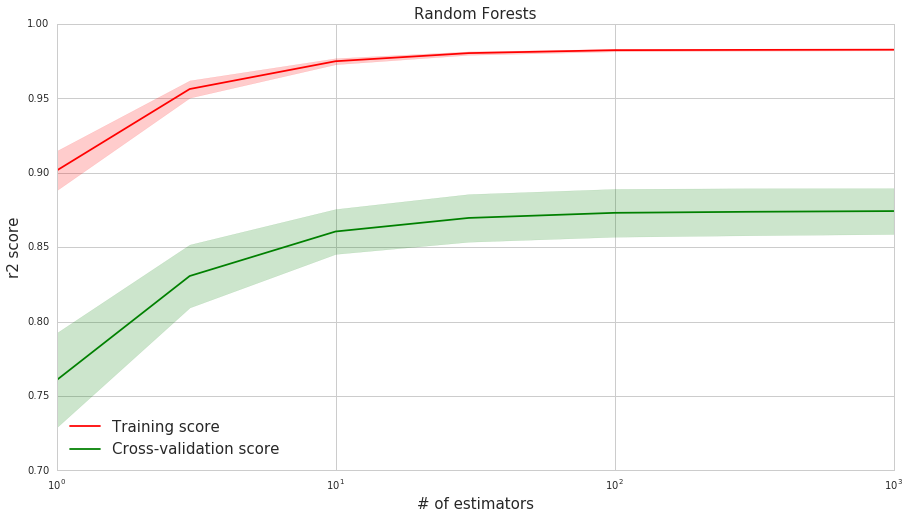

In [12]:
plot_validation_curve(estimator=RandomForestRegressor(), X=gX_train[:70000, rf_predictors], y=gy_train[:70000], 
                      param_name='n_estimators', param_range=[1,3,10,30,100,300,1000], 
                      scoring='r2', plot_title='Random Forests', x_label='# of estimators', y_label='r2 score', 
                      n_jobs=-1)

Number of estimators has a significant impact on runtime. So we will avoid large number of estimators which do not provide much performance boost.    
Score flattens around 300 estimators - this is the number of estimators we will use for the hyperparameter grid search.

Validation Curves Runtime: 0h:10m:36s


max_features:       0    Train Score: 0.982 Test Score: 0.858
max_features:       0    Train Score: 0.985 Test Score: 0.883
max_features:       0    Train Score: 0.986 Test Score: 0.892
max_features:       0    Train Score: 0.986 Test Score: 0.892
max_features:       0    Train Score: 0.986 Test Score: 0.893
max_features:       0    Train Score: 0.986 Test Score: 0.894
max_features:       0    Train Score: 0.986 Test Score: 0.893
max_features:       1    Train Score: 0.986 Test Score: 0.892


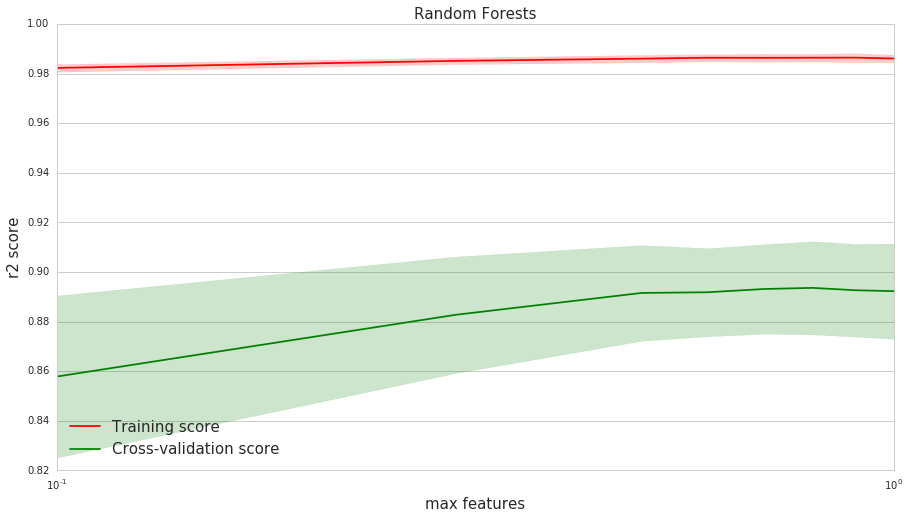

In [13]:
plot_validation_curve(estimator=RandomForestRegressor(n_estimators=300), X=gX_train[:, rf_predictors], y=gy_train, 
                      param_name='max_features', param_range=[0.1,0.3,0.5,0.6,0.7,0.8,0.9,1.0], 
                      scoring='r2', plot_title='Random Forests', x_label='max features', y_label='r2 score', 
                      n_jobs=-1)

Scores improve with a greater percentage of max features.   
We will use the full set of the reduced features for the hyperparameter grid search.

Validation Curves Runtime: 0h:32m:38s


max_depth:       1    Train Score: 0.554 Test Score: 0.487
max_depth:       5    Train Score: 0.919 Test Score: 0.873
max_depth:       7    Train Score: 0.942 Test Score: 0.883
max_depth:      10    Train Score: 0.965 Test Score: 0.888
max_depth:      11    Train Score: 0.970 Test Score: 0.891
max_depth:      12    Train Score: 0.974 Test Score: 0.891
max_depth:      13    Train Score: 0.977 Test Score: 0.890
max_depth:      14    Train Score: 0.980 Test Score: 0.891
max_depth:      15    Train Score: 0.982 Test Score: 0.892
max_depth:      16    Train Score: 0.983 Test Score: 0.890
max_depth:      17    Train Score: 0.984 Test Score: 0.890
max_depth:      18    Train Score: 0.984 Test Score: 0.891
max_depth:      19    Train Score: 0.985 Test Score: 0.890
max_depth:      20    Train Score: 0.985 Test Score: 0.891
max_depth:      21    Train Score: 0.985 Test Score: 0.891
max_depth:      22    Train Score: 0.986 Test Score: 0.890
max_depth:      

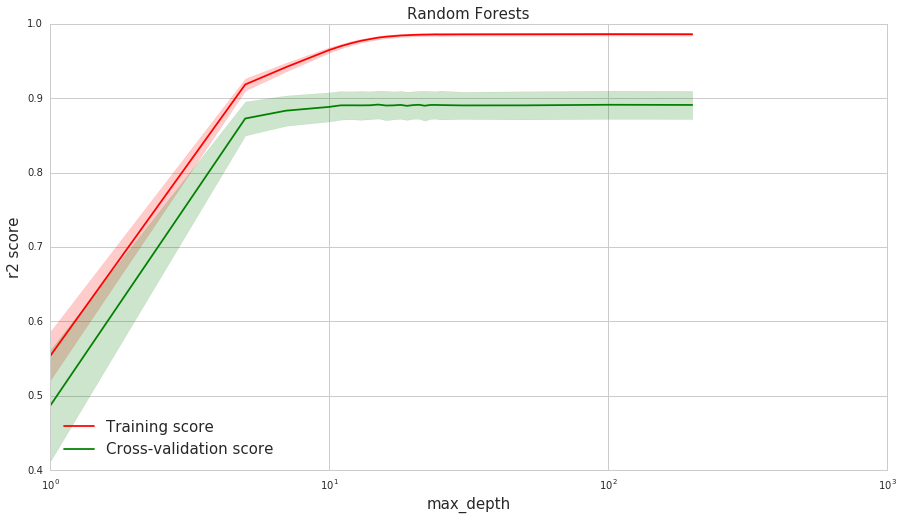

In [14]:
plot_validation_curve(estimator=RandomForestRegressor(n_estimators=300), X=gX_train[:, rf_predictors], y=gy_train, 
                      param_name='max_depth', param_range=[1,5,7,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,30,50,100,200], 
                      scoring='r2', plot_title='Random Forests', x_label='max_depth', y_label='r2 score', 
                      n_jobs=-1)

The best CV score is obtained when max_depth = 11. Higher depths lead to overfitting.   
We will use max depth values near 11 for the hyperparameter grid search.

Validation Curves Runtime: 0h:23m:31s


min_samples_split:       1    Train Score: 0.970 Test Score: 0.890
min_samples_split:       5    Train Score: 0.963 Test Score: 0.883
min_samples_split:      10    Train Score: 0.948 Test Score: 0.872
min_samples_split:      15    Train Score: 0.942 Test Score: 0.869
min_samples_split:      16    Train Score: 0.941 Test Score: 0.867
min_samples_split:      17    Train Score: 0.940 Test Score: 0.867
min_samples_split:      18    Train Score: 0.939 Test Score: 0.866
min_samples_split:      19    Train Score: 0.937 Test Score: 0.865
min_samples_split:      20    Train Score: 0.936 Test Score: 0.863
min_samples_split:      21    Train Score: 0.935 Test Score: 0.862
min_samples_split:      22    Train Score: 0.934 Test Score: 0.860
min_samples_split:      23    Train Score: 0.933 Test Score: 0.860
min_samples_split:      24    Train Score: 0.932 Test Score: 0.859
min_samples_split:      25    Train Score: 0.932 Test Score: 0.859
min_samples_split:    

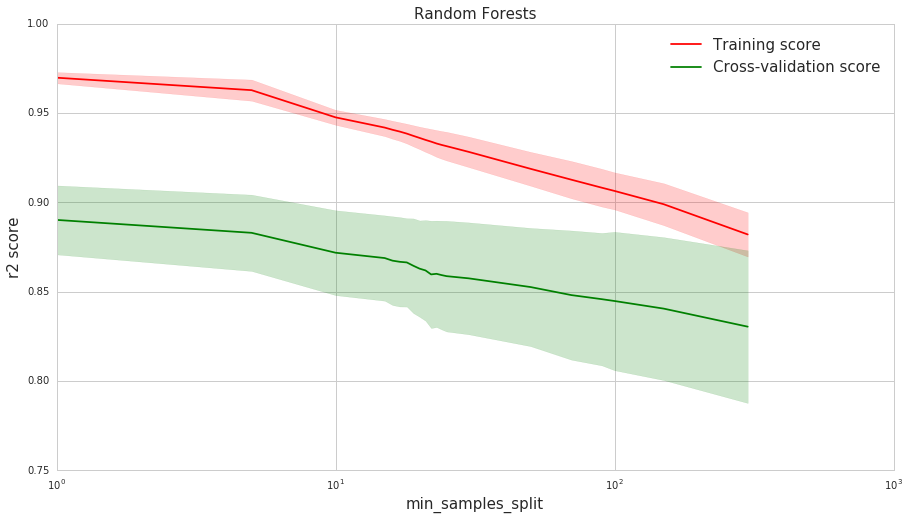

In [15]:
plot_validation_curve(estimator=RandomForestRegressor(n_estimators=300, max_depth=11), X=gX_train[:, rf_predictors], y=gy_train, 
                      param_name='min_samples_split', param_range=[1,5,10,15,16,17,18,19,20,21,22,23,24,25,30,50,70,90,100,150,300], 
                      scoring='r2', plot_title='Random Forests', x_label='min_samples_split', y_label='r2 score', 
                      n_jobs=-1)

Overfitting is observed when min samples split is below 15. Underfitting is observed with min samples split above 100.    
Variance in CV scores begins to rise when min samples split goes above 30.   
We will use min samples split in the range of 15 to 25 for the hyperparameter grid search.

Validation Curves Runtime: 0h:15m:13s


min_samples_leaf:       1    Train Score: 0.936 Test Score: 0.862
min_samples_leaf:       3    Train Score: 0.931 Test Score: 0.860
min_samples_leaf:       4    Train Score: 0.928 Test Score: 0.859
min_samples_leaf:       5    Train Score: 0.922 Test Score: 0.857
min_samples_leaf:       6    Train Score: 0.914 Test Score: 0.849
min_samples_leaf:       7    Train Score: 0.903 Test Score: 0.837
min_samples_leaf:       8    Train Score: 0.890 Test Score: 0.824
min_samples_leaf:       9    Train Score: 0.878 Test Score: 0.813
min_samples_leaf:      10    Train Score: 0.866 Test Score: 0.804
min_samples_leaf:      15    Train Score: 0.820 Test Score: 0.773
min_samples_leaf:      20    Train Score: 0.795 Test Score: 0.756
min_samples_leaf:      25    Train Score: 0.774 Test Score: 0.745
min_samples_leaf:      30    Train Score: 0.755 Test Score: 0.736


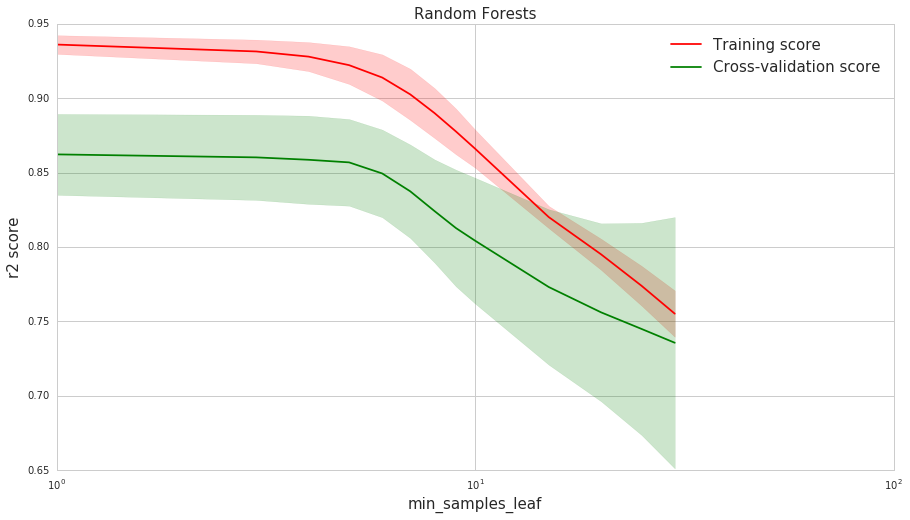

In [16]:
plot_validation_curve(estimator=RandomForestRegressor(n_estimators=300, max_depth=11, min_samples_split=20), X=gX_train[:, rf_predictors], y=gy_train, 
                      param_name='min_samples_leaf', param_range=[1,3,4,5,6,7,8,9,10,15,20,25,30], 
                      scoring='r2', plot_title='Random Forests', x_label='min_samples_leaf', y_label='r2 score', 
                      n_jobs=-1)

Overfitting is observed when min samples per leaf is below 4. Underfitting is observed above 7.     
We will use max depth in the range of 4 to 5 for the hyperparameter grid search as it seems to perform a reasonably high score without too much overfitting.

## Hyper Parameter Selection
Use parameter values picked using validation curves. Add a additional values near the optimal value for grid selection. 

GridSearchCV Runtime: 0h:27m:03s


All CV Scores: [ 0.88097265  0.8757126   0.81340849  0.6274485   0.08418371]
Mean CV Score: 0.656 +/- 0.300
Best Estimator:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features=0.8, max_leaf_nodes=None, min_samples_leaf=5,
           min_samples_split=15, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
Learning Curves Runtime: 0h:06m:57s


Train Size:    1064 Train Score: 0.719 Test Score: 0.504
Train Size:   22140 Train Score: 0.834 Test Score: 0.748
Train Size:   43216 Train Score: 0.863 Test Score: 0.795
Train Size:   64292 Train Score: 0.896 Test Score: 0.831
Train Size:   85368 Train Score: 0.918 Test Score: 0.852
Train Size:  106444 Train Score: 0.929 Test Score: 0.864


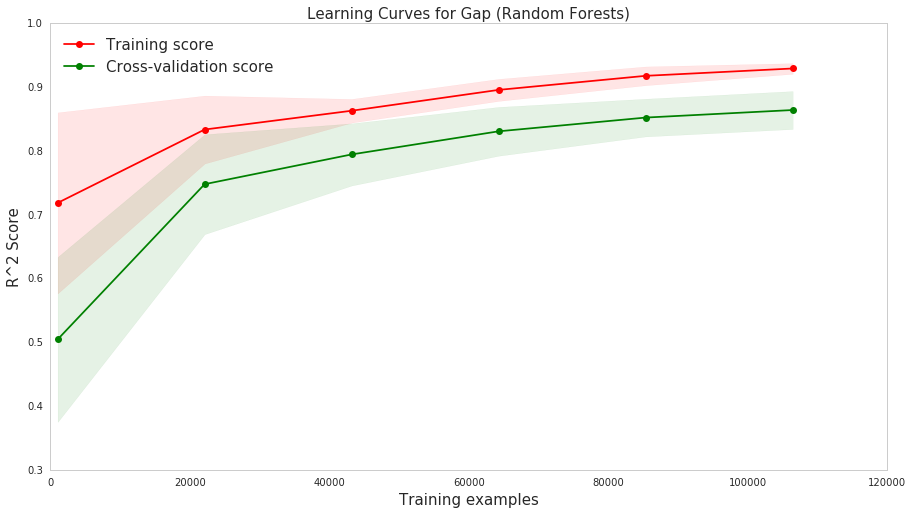



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	125.691		0.934		0.329
TEST      	277.141		0.880		0.339


In [17]:
# Use GridSearchCV - RandomForestRegressor
# Specify parameters
param_grid = {'n_estimators'      : [300],
              'max_features'      : [0.8, 1.0],
              'max_depth'         : [10, 11,12],
              'min_samples_split' : [15, 20, 25],
              'min_samples_leaf'  : [4, 5],
              'random_state'      : [0]}

alg = RandomForestRegressor()

# Only mse is supported for the RandomForestRegressor
# Use R^2 as scoring function for GridSearchCV, cross_val_score
select_hyperparams(gX_train=gX_train[:, rf_predictors], gy_train=gy_train, gX_test=gX_test[:, rf_predictors], gy_test=gy_test,
                   alg=alg, alg_name='Random Forests', param_grid=param_grid, scoring_func='r2')

# K NEAREST NEIGHBORS

In [18]:
knn_predictors = [0,3,1,5,2,8,4,19,25,26,27,28,29]

## Validation Curves

### Number of neighbors w/ uniform weights

Validation Curves Runtime: 0h:02m:07s


n_neighbors:       3    Train Score: 0.932 Test Score: 0.843
n_neighbors:       4    Train Score: 0.920 Test Score: 0.845
n_neighbors:       5    Train Score: 0.909 Test Score: 0.842
n_neighbors:       6    Train Score: 0.898 Test Score: 0.840
n_neighbors:       7    Train Score: 0.889 Test Score: 0.834
n_neighbors:       8    Train Score: 0.881 Test Score: 0.828
n_neighbors:       9    Train Score: 0.873 Test Score: 0.824
n_neighbors:      10    Train Score: 0.866 Test Score: 0.819
n_neighbors:      15    Train Score: 0.827 Test Score: 0.792
n_neighbors:      20    Train Score: 0.798 Test Score: 0.772
n_neighbors:      30    Train Score: 0.757 Test Score: 0.744


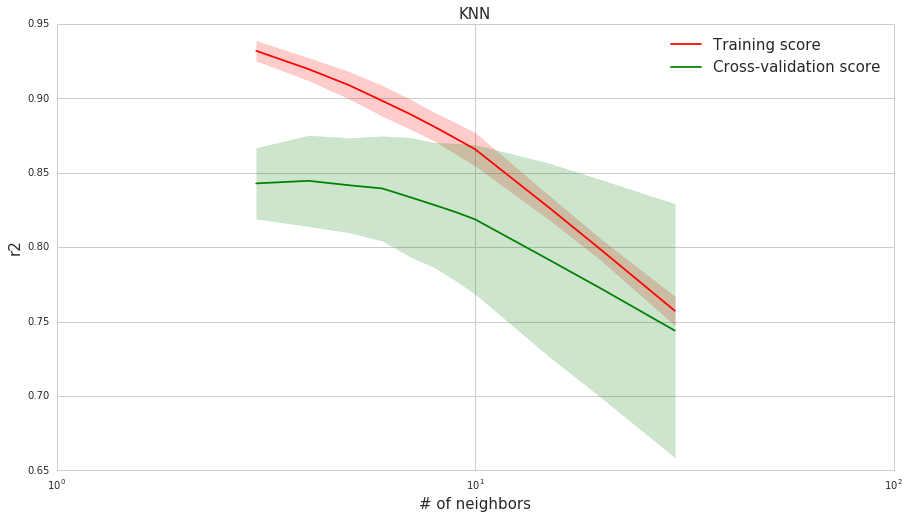

In [19]:
plot_validation_curve(estimator=KNeighborsRegressor(weights='uniform'), X=gX_train[:, knn_predictors], y=gy_train, 
                      param_name='n_neighbors', param_range=[3,4,5,6,7,8,9,10,15,20,30], 
                      scoring='r2', plot_title='KNN', x_label='# of neighbors', y_label='r2', 
                      n_jobs=-1)

Underfitting and high CV score variance is observed when number of neighbors rises above 6.    
We can use number of neighbors in the 4-6 range for the hyperparameter grid search.

## Hyper Parameter Selection

GridSearchCV Runtime: 0h:00m:59s


All CV Scores: [ 0.83502661  0.82556696  0.77149492  0.56538357 -0.3964854 ]
Mean CV Score: 0.520 +/- 0.469
Best Estimator:
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
          metric_params=None, n_jobs=1, n_neighbors=6, p=2,
          weights='uniform')
Learning Curves Runtime: 0h:01m:04s


Train Size:    1064 Train Score: 0.691 Test Score: 0.490
Train Size:   22140 Train Score: 0.820 Test Score: 0.745
Train Size:   43216 Train Score: 0.850 Test Score: 0.786
Train Size:   64292 Train Score: 0.879 Test Score: 0.817
Train Size:   85368 Train Score: 0.894 Test Score: 0.828
Train Size:  106444 Train Score: 0.900 Test Score: 0.837


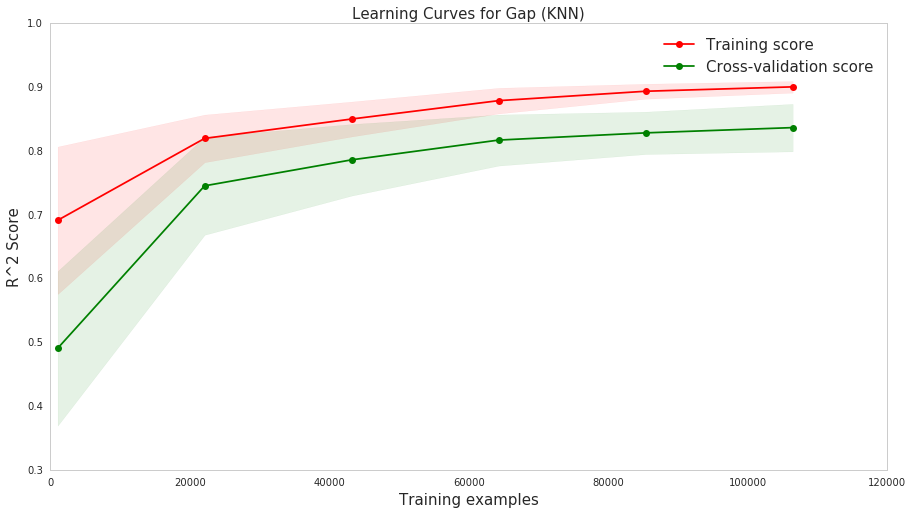



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	179.380		0.906		0.317
TEST      	338.005		0.854		0.381


In [20]:
# Specify parameters
param_grid = {'n_neighbors' : [4, 5, 6],
              'weights'     : ['uniform'],
              'metric'      : ['euclidean', 'minkowski']}

alg = KNeighborsRegressor()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, knn_predictors], gy_train=gy_train, gX_test=gX_test[:, knn_predictors], gy_test=gy_test,
                   alg=alg, alg_name='KNN', param_grid=param_grid, scoring_func='r2')

# GRADIENT BOOSTED TREES

## Validation Curves

Validation Curves Runtime: 0h:02m:07s


learning_rate:       0    Train Score: 0.770 Test Score: 0.739
learning_rate:       0    Train Score: 0.949 Test Score: 0.901
learning_rate:       0    Train Score: 0.956 Test Score: 0.901
learning_rate:       0    Train Score: 0.961 Test Score: 0.903
learning_rate:       0    Train Score: 0.967 Test Score: 0.899
learning_rate:       0    Train Score: 0.969 Test Score: 0.891
learning_rate:       0    Train Score: 0.971 Test Score: 0.896
learning_rate:       0    Train Score: 0.974 Test Score: 0.899
learning_rate:       0    Train Score: 0.975 Test Score: 0.877
learning_rate:       0    Train Score: 0.977 Test Score: 0.874


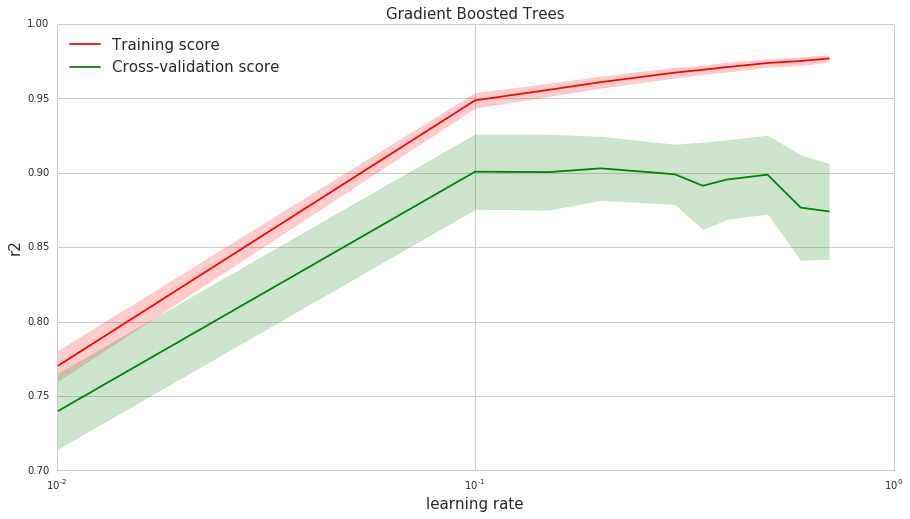

In [22]:
gbr_predictors = [0,3,2,1,20,9,5,19,25,26,27,28,29] 

plot_validation_curve(estimator=GradientBoostingRegressor(), X=gX_train[:, gbr_predictors], y=gy_train, 
                      param_name='learning_rate', param_range=[0.01,0.1,0.15,0.2,0.3,0.35,0.4,0.5,0.6,0.7], 
                      scoring='r2', plot_title='Gradient Boosted Trees', x_label='learning rate', y_label='r2', 
                      n_jobs=-1)

The best CV scores are observed with learning rate of 0.1, 0.2. Since higher values lead to overfitting, we will use 0.1 for learning rate.

Validation Curves Runtime: 0h:03m:04s


n_estimators:      10    Train Score: 0.781 Test Score: 0.749
n_estimators:     100    Train Score: 0.949 Test Score: 0.901
n_estimators:     150    Train Score: 0.956 Test Score: 0.904
n_estimators:     200    Train Score: 0.961 Test Score: 0.907
n_estimators:     250    Train Score: 0.965 Test Score: 0.908
n_estimators:     300    Train Score: 0.968 Test Score: 0.909
n_estimators:     400    Train Score: 0.972 Test Score: 0.911


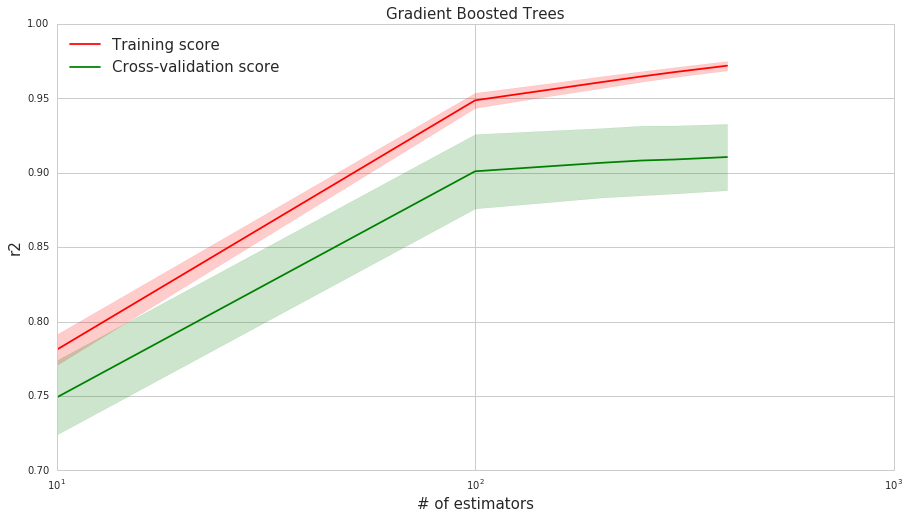

In [23]:
plot_validation_curve(estimator=GradientBoostingRegressor(learning_rate=0.1), X=gX_train[:, gbr_predictors], y=gy_train, 
                      param_name='n_estimators', param_range=[10,100,150,200,250,300,400], 
                      scoring='r2', plot_title='Gradient Boosted Trees', x_label='# of estimators', y_label='r2', 
                      n_jobs=-1)

Overfitting is observed when number of estimators is above 200.    
We will use 200 estimators for the hyperparameter grid search. This level has a lower amount of overfitting and still delivers most of the CV score.

Validation Curves Runtime: 0h:04m:31s


max_depth:       3    Train Score: 0.961 Test Score: 0.906
max_depth:       4    Train Score: 0.974 Test Score: 0.910
max_depth:       5    Train Score: 0.983 Test Score: 0.913
max_depth:       6    Train Score: 0.989 Test Score: 0.911
max_depth:       7    Train Score: 0.993 Test Score: 0.914


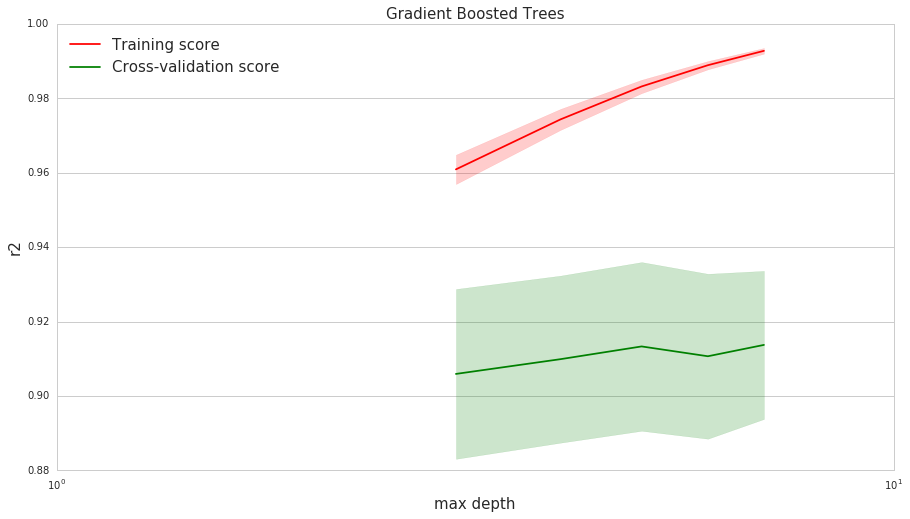

In [24]:
plot_validation_curve(estimator=GradientBoostingRegressor(learning_rate=0.1, n_estimators=200), 
                      X=gX_train[:, gbr_predictors], y=gy_train, 
                      param_name='max_depth', param_range=[3,4,5,6,7], 
                      scoring='r2', plot_title='Gradient Boosted Trees', x_label='max depth', y_label='r2', 
                      n_jobs=-1)

Overfitting is observed when max depth is above 5.    
We will use max depth of 5 for the hyperparameter grid search. This value delivers a reasonably high score without too much overfitting.

Validation Curves Runtime: 0h:09m:23s


min_samples_split:       1    Train Score: 0.983 Test Score: 0.912
min_samples_split:       3    Train Score: 0.983 Test Score: 0.913
min_samples_split:       4    Train Score: 0.983 Test Score: 0.911
min_samples_split:       5    Train Score: 0.983 Test Score: 0.910
min_samples_split:       6    Train Score: 0.982 Test Score: 0.912
min_samples_split:       7    Train Score: 0.982 Test Score: 0.912
min_samples_split:       8    Train Score: 0.981 Test Score: 0.910
min_samples_split:       9    Train Score: 0.981 Test Score: 0.911
min_samples_split:      10    Train Score: 0.981 Test Score: 0.908
min_samples_split:      15    Train Score: 0.979 Test Score: 0.909
min_samples_split:      20    Train Score: 0.979 Test Score: 0.905
min_samples_split:      30    Train Score: 0.977 Test Score: 0.904


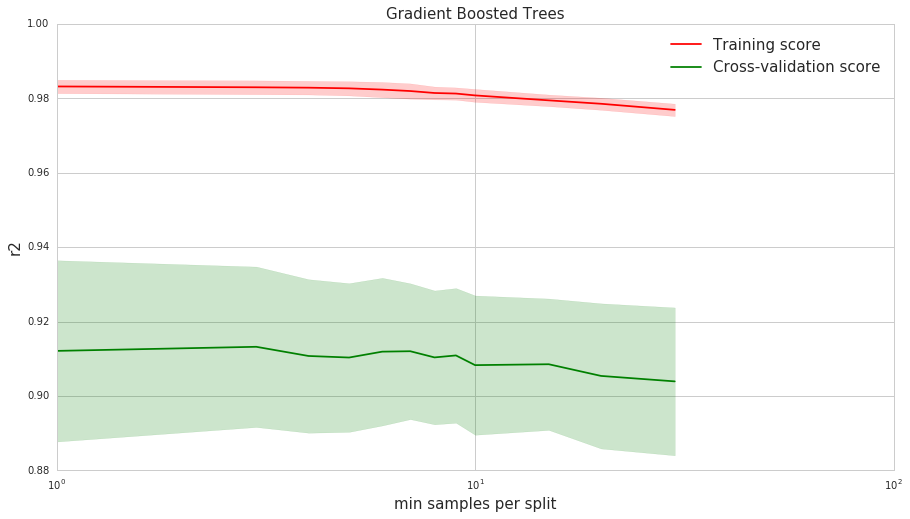

In [25]:
plot_validation_curve(estimator=GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth=5), 
                      X=gX_train[:, gbr_predictors], y=gy_train, 
                      param_name='min_samples_split', param_range=[1,3,4,5,6,7,8,9,10,15,20,30], 
                      scoring='r2', plot_title='Gradient Boosted Trees', x_label='min samples per split', y_label='r2', 
                      n_jobs=-1)

Best CV scores are observed for min samples per split in the range of 1 to 8.    
We will use the higher values (6,7) to ensure less overfitting.

Validation Curves Runtime: 0h:04m:37s


min_samples_leaf:       1    Train Score: 0.982 Test Score: 0.912
min_samples_leaf:       2    Train Score: 0.982 Test Score: 0.914
min_samples_leaf:       3    Train Score: 0.982 Test Score: 0.915
min_samples_leaf:       4    Train Score: 0.980 Test Score: 0.914
min_samples_leaf:       5    Train Score: 0.978 Test Score: 0.917
min_samples_leaf:       7    Train Score: 0.970 Test Score: 0.911


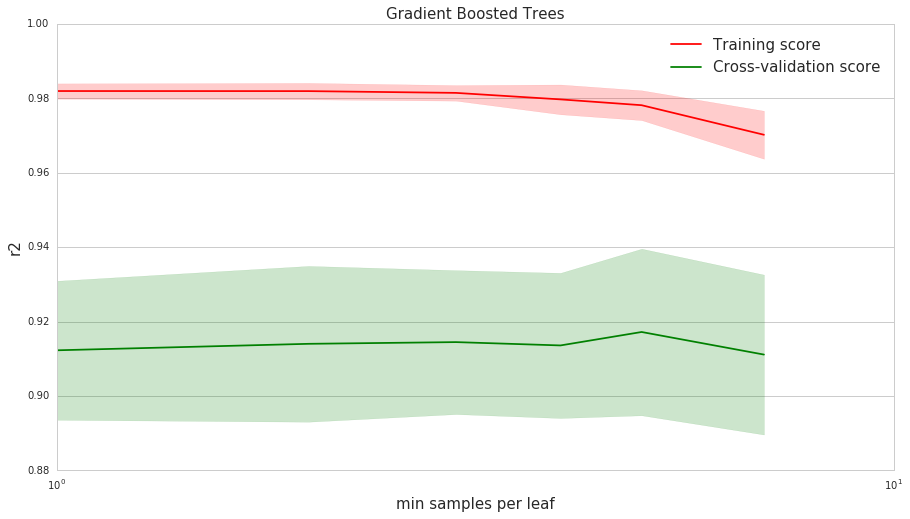

In [26]:
plot_validation_curve(estimator=GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth=5, min_samples_split=7),
                      X=gX_train[:, gbr_predictors], y=gy_train, 
                      param_name='min_samples_leaf', param_range=[1,2,3,4,5,7], 
                      scoring='r2', plot_title='Gradient Boosted Trees', x_label='min samples per leaf', y_label='r2', 
                      n_jobs=-1)

The best CV score is observed with minimum samples per leaf at 3.

Validation Curves Runtime: 0h:05m:04s


subsample:       0    Train Score: 0.917 Test Score: 0.832
subsample:       0    Train Score: 0.964 Test Score: 0.892
subsample:       0    Train Score: 0.974 Test Score: 0.902
subsample:       0    Train Score: 0.977 Test Score: 0.904
subsample:       0    Train Score: 0.978 Test Score: 0.907
subsample:       0    Train Score: 0.979 Test Score: 0.906
subsample:       0    Train Score: 0.979 Test Score: 0.910
subsample:       0    Train Score: 0.981 Test Score: 0.911
subsample:       1    Train Score: 0.982 Test Score: 0.915


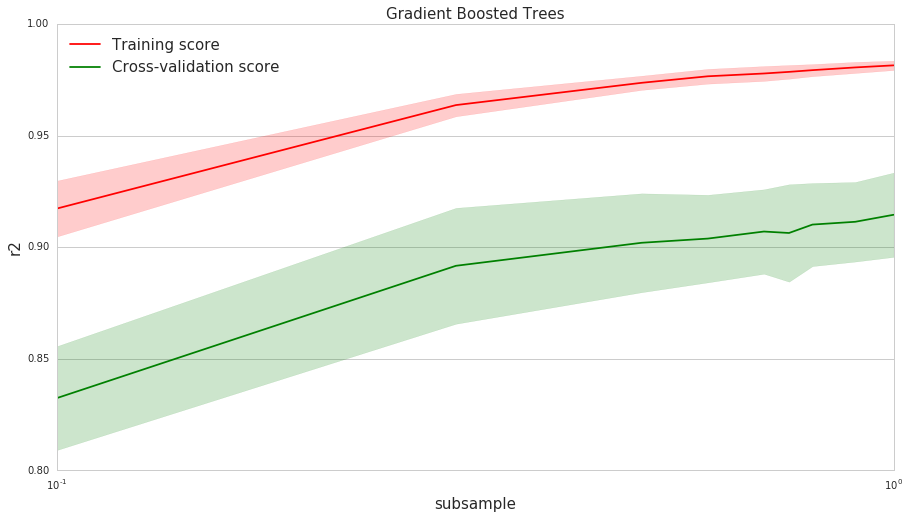

In [27]:
plot_validation_curve(estimator=GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth=5, min_samples_split=7, min_samples_leaf=3), 
                      X=gX_train[:, gbr_predictors], y=gy_train, 
                      param_name='subsample', param_range=[0.1,0.3,0.5,0.6,0.7,0.75,0.8,0.9,1.0], 
                      scoring='r2', plot_title='Gradient Boosted Trees', x_label='subsample', y_label='r2', 
                      n_jobs=-1)

The best CV score is observed with subsample at 1.0

## Hyper Parameter Selection

GridSearchCV Runtime: 0h:03m:17s


All CV Scores: [ 0.89732912  0.76401823  0.83597597  0.56162288  0.04328485]
Mean CV Score: 0.620 +/- 0.310
Best Estimator:
GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=5, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=3, min_samples_split=6,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
Learning Curves Runtime: 0h:05m:09s


Train Size:    1064 Train Score: 0.998 Test Score: 0.234
Train Size:   22140 Train Score: 0.987 Test Score: 0.813
Train Size:   43216 Train Score: 0.986 Test Score: 0.872
Train Size:   64292 Train Score: 0.986 Test Score: 0.894
Train Size:   85368 Train Score: 0.984 Test Score: 0.897
Train Size:  106444 Train Score: 0.982 Test Score: 0.908


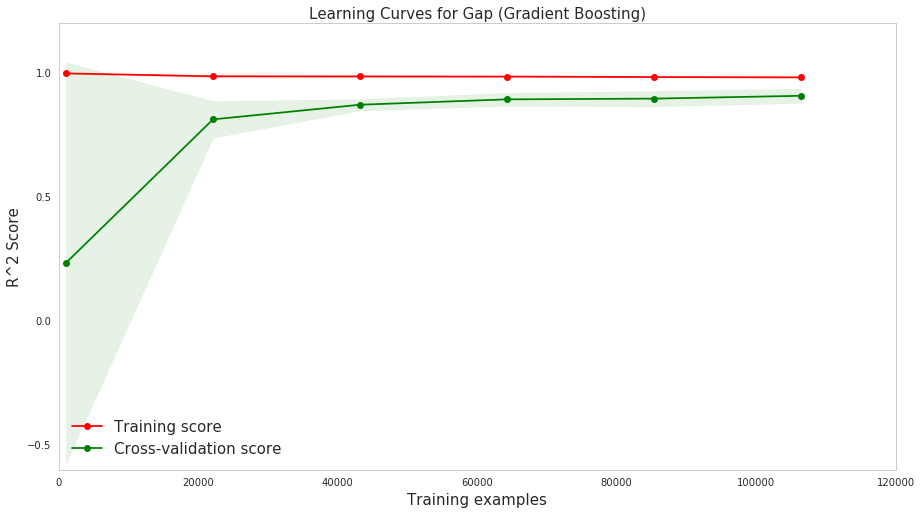



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	37.397		0.980		0.335
TEST      	260.128		0.888		0.358


In [28]:
# No parameters to select
param_grid = {'learning_rate'          : [0.1],
              'n_estimators'           : [200],
              'max_depth'              : [5],
              'min_samples_split'      : [6,7],
              'min_samples_leaf'       : [3],
              'subsample'              : [1.0]
             }

alg = GradientBoostingRegressor()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, gbr_predictors], gy_train=gy_train, gX_test=gX_test[:, gbr_predictors], 
                   gy_test=gy_test, alg=alg, alg_name='Gradient Boosting', param_grid=param_grid, scoring_func='r2')